In [63]:
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# for data manipulation and graphing
from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

Taking all the csv files from the directory and joining them in one dataset

In [64]:
# Obtén una lista de todos los archivos CSV en la carpeta
csv_files = glob.glob('C:/Users/franc/pasantia_IA/datasets/by_points/*.csv')

datasets = [pd.read_csv(file) for file in csv_files]

dataset = pd.concat(datasets, ignore_index=True)

In [3]:
dataset.head()

,ID,Issue_Key,Type,Status,Resolution,Creation_Date,Resolution_Date,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes
0,384741,APIKIT-77,Enhancement Request,Closed,Fixed,2013-05-03 18:25:11,2014-08-14 23:32:03,8.0,NaN,0,0,674226
1,384774,APIKIT-31,Bug,Closed,Fixed,2013-07-09 00:25:17,2013-07-15 20:30:29,1.0,NaN,0,0,9845
2,384770,APIKIT-38,Bug,Closed,Fixed,2013-07-10 02:35:20,2013-08-16 19:52:51,8.0,NaN,0,0,54317
3,384769,APIKIT-39,Bug,Closed,Fixed,2013-07-10 03:10:02,2013-07-19 18:34:24,2.0,NaN,0,0,13884
4,384767,APIKIT-41,Bug,Closed,Fixed,2013-07-10 19:44:35,2013-07-15 20:27:39,1.0,NaN,54,54,7243


In [4]:
# show the metadata
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54109 entries, 0 to 54108
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       54109 non-null  int64  
 1   Issue_Key                54109 non-null  object 
 2   Type                     47205 non-null  object 
 3   Status                   47205 non-null  object 
 4   Resolution               54109 non-null  object 
 5   Creation_Date            47205 non-null  object 
 6   Resolution_Date          47186 non-null  object 
 7   Story_Point              47824 non-null  float64
 8   Timespent                7540 non-null   float64
 9   In_Progress_Minutes      54109 non-null  int64  
 10  Total_Effort_Minutes     54109 non-null  int64  
 11  Resolution_Time_Minutes  54109 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 5.0+ MB


### Cleaning the data

We will select only the columns that are high relevant to this study, also we will drop all the samples with NaN values, the ones that has zero in time_effort or with a time higher that 100 hours

In [8]:
clean_dataset = dataset[[
    'Type',
    'Story_Point',
    'Total_Effort_Minutes'
    # 'Resolution_Time_Minutes'
]]

clean_dataset = clean_dataset[
    (clean_dataset['Type'] != 'Question') |
    (clean_dataset['Type'] != 'Epic') |
    (clean_dataset['Type'] != 'Documentation') |
    (clean_dataset['Type'] != 'Suggestion') |
    (clean_dataset['Type'] != 'Wish')
]

clean_dataset = clean_dataset[[
    'Story_Point',
    'Total_Effort_Minutes'
]]

Clean all the NaN values

In [9]:
clean_dataset = clean_dataset.dropna()

Converting the time values from minutes to hours and approximating story_points ​​to integers

In [12]:
clean_dataset['Total_Effort_Minutes'] = clean_dataset['Total_Effort_Minutes'] / 60
clean_dataset['Story_Point'] = clean_dataset['Story_Point'].round().astype(int)

In [13]:
min_value = clean_dataset['Story_Point'].min()
max_value = clean_dataset['Story_Point'].max()

print(f'Min: {min_value}, Max: {max_value}')

Min: 0, Max: 100


In [14]:
clean_dataset = clean_dataset[clean_dataset['Total_Effort_Minutes'] <= 100]
clean_dataset = clean_dataset[(clean_dataset['Story_Point'] != 0) & (clean_dataset['Story_Point'] < 17)]

In [15]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45162 entries, 0 to 54108
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Story_Point           45162 non-null  int32  
 1   Total_Effort_Minutes  45162 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 882.1 KB


Desnormalizing data

In [97]:
clean_dataset = pd.get_dummies(clean_dataset, columns=['Type'])
clean_dataset = clean_dataset.astype(int)

In [16]:
clean_dataset.head()

,Story_Point,Total_Effort_Minutes
0,8,0.000
1,1,0.000
2,8,0.000
3,2,0.000
4,1,0.015


In [17]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45162 entries, 0 to 54108
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Story_Point           45162 non-null  int32  
 1   Total_Effort_Minutes  45162 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 882.1 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [18]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.20)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (36129, 2)
    Test: (4517, 2)
    Validation: (4516, 2)


### Data analysis

Calculate the correlation and other statistics on the train dataset

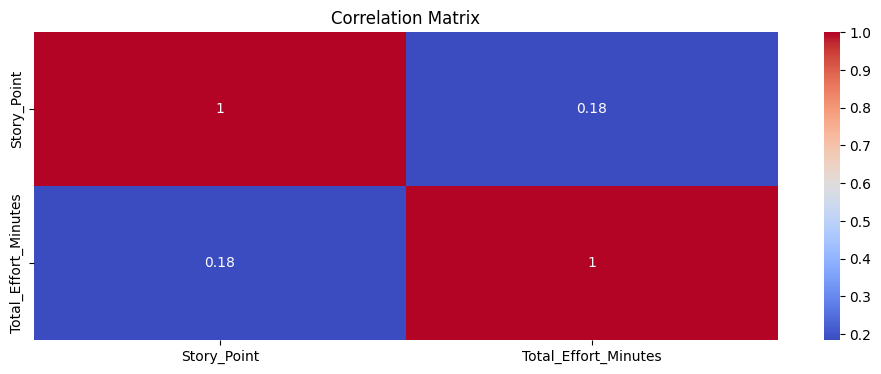

In [19]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Total_Effort_Minutes'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [20]:
# another interesting statistics like the count, mean, std, min, quartiles and max, all per feature
train_stats = train_dataset.describe()
train_stats.pop('Total_Effort_Minutes')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Story_Point,36129.0,3.694484,3.048552,1.0,1.0,3.0,5.0,16.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [21]:
train_label = train_dataset.pop('Total_Effort_Minutes')
test_label = test_dataset.pop('Total_Effort_Minutes')
validation_label = validation_dataset.pop('Total_Effort_Minutes')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [23]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# is some of the data is NaN, fill it with 1
# if normed_train_data['Total_developers'].isna().any():
#     normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
#     normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)
#     normed_validation_data['Total_developers'] = normed_validation_data['Total_developers'].fillna(1)

In [24]:
# show a part of the normalized data
normed_train_data.head()

,Story_Point
51807,-0.227808
19785,-0.555832
40862,-0.227808
13857,-0.555832
40522,-0.555832


## Building the Models

### Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [25]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [26]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(128, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(32, Activation('relu'), name='hidden_layer_2'))
    
    
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Third Model

Five hidden layers, all with 64 neurons

Learning rate at 0.001

In [27]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "ThirdModelFiveHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Fourth Model

Recurrent Neural Network

In [75]:
def build_fourth_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Reshape(
        (normed_train_data.shape[1], 1),
        input_shape=(normed_train_data.shape[1],)
    ))

    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(PReLU())
    model.add(Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(PReLU())
    model.add(Dense(1))

    learning_rate = 0.001
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse'])

    return model 

### Fith Model

Support Vector Machine

In [29]:
def build_model_svc():
    parameters = {'kernel':('linear', 'rbf')}
    svr = SVR()
    return GridSearchCV(svr, parameters)

### Choose the model

In [30]:
def choose_model(model_type, model_number):
    if (model_type == 'Neuronal Network'):
        if (model_number == 1):
            return build_first_model_two_hidden_layers()
        elif (model_number == 2):
            return build_second_model_three_hidden_layers()
        elif (model_number == 3):
            return build_third_model_five_hidden_layers()
        elif (model_number == 4):
            return build_fourth_model_LSTM_hidden_layers()
    else:
        return build_model_svc()

Save checkpoints during training

In [31]:
# checkpoint_path = r".\checkpoint_logs\connectium\data.ckpt"
checkpoint_path = r".\checkpoint_logs\data.weights.h5"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)

## Model training

In [84]:
def training_neural_network_model(model):
        
        # for first model - second place
        # epochs = 200
        # batch_size = 200 

        # for second model - worst for now
        # epochs = 400
        # batch_size = 60

        # for third model -
        epochs = 64
        batch_size = 10

        # for fourth model - is winning
        # epochs = 100
        # batch_size = 64

        history = model.fit(
            normed_train_data,
            train_label,
            batch_size=batch_size,  
            epochs=epochs, 
            verbose=0,
            shuffle=True,
            steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
            validation_data=(normed_validation_data, validation_label),
            callbacks=[
                tfdocs.modeling.EpochDots(),
                tensorboard_callback,
                ckpt_callback,
            ]
        )

        return history

In [45]:
def training_support_vector_machine_model(model):
    model.fit(normed_train_data, train_label)
    
    history = pd.DataFrame({
        'Accuracy': [model.score(normed_test_data, test_label)],
        'Best params hash': [model.best_params_],
        'Best score': [model.best_score_],
        'Best estimator': [model.best_estimator_],
    })

    print(history)
    return history

In [90]:
%%time

# model = choose_model('Neuronal Network', 3)
model = choose_model('Support Vector Machine', 0)

# history = training_neural_network_model(model)
history = training_support_vector_machine_model(model)

   Accuracy   Best params hash  Best score Best estimator
0 -0.080447  {'kernel': 'rbf'}   -0.077991          SVR()
CPU times: total: 5min 37s
Wall time: 6min 33s


## Predicting the data

### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [91]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)

print("Example for the first 5 samples")
print("Predicted Hours Logged")
print(example_result)
    
print("Real Hours Logged")
print(train_label[:5])

test_predictions = model.predict(normed_test_data)

Example for the first 5 samples
Predicted Hours Logged
[1.27188186 0.67106049 1.27188186 0.67106049 0.67106049]
Real Hours Logged
51807     3.078333
19785     0.936667
40862    41.184722
13857     0.345000
40522     1.592222
Name: Total_Effort_Minutes, dtype: float64


In [92]:
test_predictions = model.predict(normed_test_data).flatten()

predictions_dataset = pd.DataFrame({
    'Logged': test_label,
    'Predicted': test_predictions
})

# test_predictions_to_csv = pd.DataFrame(test_predictions).to_csv(r"./outputs/neural_network/test_predictions_sip.csv", index=False)
# test_label_to_csv = pd.DataFrame(test_label).to_csv(r"./outputs/neural_network/test_label_sip.csv", index=False)

predictions_dataset_csv = predictions_dataset
predictions_dataset_csv.to_csv(r"./outputs/neural_network/predictions_sip.csv", index=False)

Predictions VS. True Values for Hours Logged

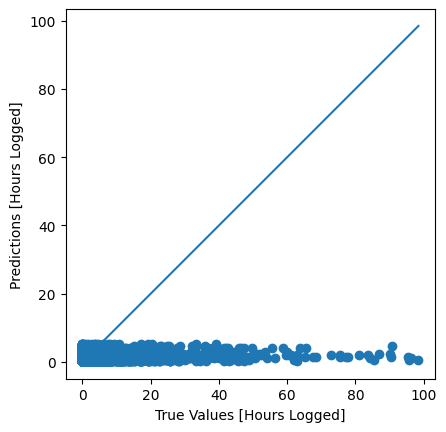

In [93]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value])
plt.savefig(r"./outputs/neural_network/prediction_plot_sip.png")

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

### Showing the resulting metrics from the training

In [82]:
def evaluating_neural_network_model(history):

    history_dataset = pd.DataFrame(history.history)
    history_dataset['epoch'] = history.epoch


    print("Resume of the training history model")
    display(HTML(history_dataset.tail(5).to_html()))

    history_dataset_csv = history_dataset
    history_dataset_csv.to_csv(r"./outputs/neural_network/history_sip.csv", index=False)  

    print("Plotting the training history model per epoch")

    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Basic': history}, metric="mse")
    plt.ylabel('MSE [Metric]')

    plt.savefig(r"./outputs/neural_network/training_plot_sip.png")
    plt.show()


In [72]:
def evaluating_svc_model(history, test_predictions):
    history['MAE'] = [mean_absolute_error(test_label, test_predictions)]
    history['MSE'] = [mean_squared_error(test_label, test_predictions)]

    display(HTML(history.to_html()))

    history.to_csv(r"./outputs/svr/history_sip.csv", index=False)   

    # saving the results
    pd.DataFrame({
        'Logged': test_label,
        'Predicted': test_predictions
    }).to_csv(r"./outputs/svr/history_sip.csv", index=False)

In [95]:
# evaluating_neural_network_model(history)
evaluating_svc_model(history, test_predictions)

,Accuracy,Best params hash,Best score,Best estimator,MAE,MSE
0,-0.080447,{'kernel': 'rbf'},-0.077991,SVR(),4.222345,103.718878


In [50]:
model.save(r"./outputs/neural_network/model_sip.h5")

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
import netron
netron.start(r"./outputs/neural_network/model_sip.h5")

Serving './outputs/neural_network/model_sip.h5' at http://localhost:8080


('localhost', 8080)